## Automatic Sentiment Analysis Tool for Urdu Text on Social Media Platforms

## Importing Libraries

In [4]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import urduhack
from urduhack.preprocessing import normalize_whitespace
from urduhack.preprocessing import remove_punctuation
from urduhack.preprocessing import remove_accents
import demoji
import spacy

## Loading Dataset

In [5]:
df=pd.read_csv('urdu_sarcastic_dataset.csv')
df.head()
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7'], inplace=True)
df.head()


,urdu_text,is_sarcastic
0,🤣😂😂 ہو لینے دے میری شادی فسادن ٹھیک ہے کوجی نہ...,1.0
1,چل مہمانوں میں کھانا سرو کر چڑیل چاچی نوں دسدی...,1.0
2,کامران خان آپکی دن بھریہ زمہ داری لگائی گئی اپ...,0.0
3,نہیں پائین 😎,0.0
4,`` مراد علی شاہ کے بھیس میں ڈی جی آئی ایس آئی...,1.0


## Visualization

C:\Users\SaadS\AppData\Local\Temp\ipykernel_8364\3110790268.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_sarcastic', data=df, palette='Set2')


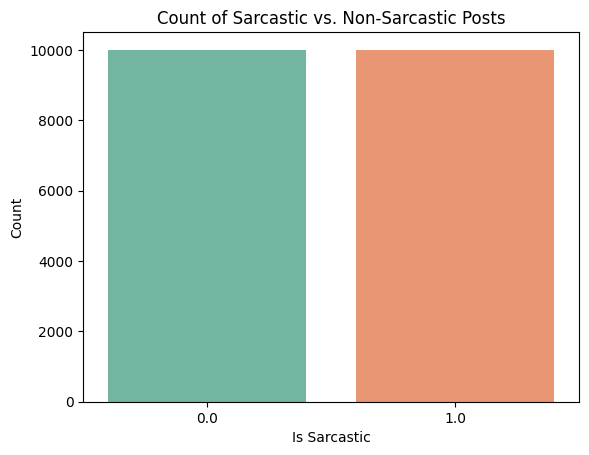

In [6]:
sns.countplot(x='is_sarcastic', data=df, palette='Set2')
plt.title('Count of Sarcastic vs. Non-Sarcastic Posts')
plt.xlabel('Is Sarcastic')
plt.ylabel('Count')

plt.show()

## Text Preprocessing

In [7]:
# Making a list of stopwords
with open("stopwords-ur.txt", 'r', encoding='utf-8') as file:
        stopwords_from_file = file.read().splitlines()

stopdf=pd.read_csv("urdu_stopwords.csv",encoding='utf-8')
stopwords_from_csv = stopdf["stopword"].tolist()

# Additional stopwords
stop_words = set("""

 آ آئی آئیں آئے آتا آتی آتے آداب آدھ آدھا آدھی آدھے آس آمدید آنا آنسہ آنی آنے
 آپ آگے آہ آہا آیا اب ابھی ابے اتوار ارب اربویں ارے اس اسکا اسکی اسکے اسی اسے اف
 افوہ الاول البتہ الثانی الحرام السلام الف المکرم ان اندر انکا انکی انکے انہوں انہی انہیں اوئے اور
 اوپر اوہو اپ اپنا اپنوں اپنی اپنے اپنےآپ اکبر اکثر اگر اگرچہ اگست اہاہا ایسا ایسی ایسے ایک بائیں
 بار بارے بالکل باوجود باہر بج بجے بخیر برسات بشرطیکہ بعد بعض بغیر بلکہ بن بنا بناؤ بند
 بڑی بھر بھریں بھی بہار بہت بہتر بیگم تاکہ تاہم تب تجھ تجھی تجھے ترا تری تلک تم تمام
 تمہارا تمہاروں تمہاری تمہارے تمہیں تو تک تھا تھی تھیں تھے تہائی تیرا تیری تیرے تین جا جاؤ
 جائیں جائے جاتا جاتی جاتے جانی جانے جب جبکہ جدھر جس جسے جن جناب جنہوں جنہیں جو جہاں جی
 جیسا جیسوں جیسی جیسے جیٹھ حالانکہ حالاں حصہ حضرت خاطر خالی خدا خزاں خواہ خوب خود دائیں درمیان
 دریں دو دوران دوسرا دوسروں دوسری دوشنبہ دوں دکھائیں دگنا دی دیئے دیا دیتا دیتی دیتے دیر دینا دینی
 دینے دیکھو دیں دیے دے ذریعے رکھا رکھتا رکھتی رکھتے رکھنا رکھنی رکھنے رکھو رکھی رکھے رہ رہا
 رہتا رہتی رہتے رہنا رہنی رہنے رہو رہی رہیں رہے ساتھ سامنے ساڑھے سب سبھی سراسر سلام سمیت سوا
 سوائے سکا سکتا سکتے سہ سہی سی سے شام شاید شکریہ صاحب صاحبہ صرف ضرور طرح طرف طور
 علاوہ عین فروری فقط فلاں فی قبل قطا لئے لائی لائے لاتا لاتی لاتے لانا لانی لانے لایا لو
 لوجی لوگوں لگ لگا لگتا لگتی لگی لگیں لگے لہذا لی لیا لیتا لیتی لیتے لیکن لیں لیے
 لے ماسوا مت مجھ مجھی مجھے محترم محترمہ محترمی محض مرا مرحبا مری مرے مزید مس مسز مسٹر مطابق
 مطلق مل منٹ منٹوں مکرمی مگر مگھر مہربانی میرا میروں میری میرے میں نا نزدیک نما نو نومبر
 نہ نہیں نیز نیچے نے و وار واسطے واقعی والا والوں والی والے واہ وجہ ورنہ وعلیکم وغیرہ ولے
 وگرنہ وہ وہاں وہی وہیں ویسا ویسے ویں پاس پایا پر پس پلیز پون پونا پونی پونے پھاگن
 پھر پہ پہر پہلا پہلی پہلے پیر پیچھے چاہئے چاہتے چاہیئے چاہے چلا چلو چلیں چلے چناچہ چند چونکہ
 چوگنی چکی چکیں چکے چہارشنبہ چیت ڈالنا ڈالنی ڈالنے ڈالے کئے کا کاتک کاش کب کبھی کدھر کر
 کرتا کرتی کرتے کرم کرنا کرنے کرو کریں کرے کس کسی کسے کل کم کن کنہیں کو کوئی کون
 کونسا کونسے کچھ کہ کہا کہاں کہہ کہی کہیں کہے کی کیا کیسا کیسے کیونکر کیونکہ کیوں کیے
 کے گئی گئے گا گرما گرمی گنا گو گویا گھنٹا گھنٹوں گھنٹے گی گیا ہائیں ہائے ہاڑ ہاں ہر
 ہرچند ہرگز ہزار ہفتہ ہم ہمارا ہماری ہمارے ہمی ہمیں ہو ہوئی ہوئیں ہوئے ہوا ہوبہو ہوتا ہوتی
 ہوتیں ہوتے ہونا ہونگے ہونی ہونے ہوں ہی ہیلو ہیں ہے یا یات یعنی یک یہ یہاں یہی یہیں


""".split())

final_stopwords = set(stopwords_from_file + stopwords_from_csv)
final_stopwords.update(stop_words) 


In [8]:
# checking if stopwords contain any sentiment words
urdu_sentiment_words = ["نہیں", "برا", "خوش", "اچھا"]
found=[]
for stopword in final_stopwords:
    if stopword in urdu_sentiment_words:
        found.append(stopword)

if found:
    print("Sentiment words found in stopwords:", found)
    final_stopwords.update(found)
else:
    print("No sentiment words found in stopwords.")


Sentiment words found in stopwords: ['نہیں']


## Removing Null Values

In [9]:
print(df["urdu_text"].isnull().sum())
df.dropna(subset=['urdu_text', 'is_sarcastic'], inplace=True)

105


## Numbers Removal

In [10]:
def remove_numbers(x):
    return re.sub(r'\d+', '', x)

In [11]:
df["urdu_text"]=df["urdu_text"].apply(remove_numbers)
# print(df["urdu_text"][12])
# print(remove_numbers(df["urdu_text"][12]))

## Emojis Removal

In [12]:

def remove_emoji(text):
    emoji_pattern = re.compile("["  
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  
        u"\U000024C2-\U0001F251"  
        u"\U0001F900-\U0001F9FF"  # additional emojis
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [13]:
df["urdu_text"]=df["urdu_text"].apply(remove_emoji)
# print(df["urdu_text"][0])
# print(remove_emoji(df["urdu_text"][0]))
# using demoji library to remove emojis
demoji.download_codes()
df["urdu_text"]=df["urdu_text"].apply(demoji.replace)

C:\Users\SaadS\AppData\Local\Temp\ipykernel_8364\3957368967.py:5: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


## Hashtag and Mentions Removal

In [14]:
def remove_hash_sign(text):
    return re.sub(r'#', '', text)  

def remove_mentions(text):
    return re.sub(r'@\w+', '', text) 

In [15]:
df["urdu_text"]=df["urdu_text"].apply(remove_hash_sign)
print(df["urdu_text"][5277])
print(df["urdu_text"][5612])
df["urdu_text"]=df["urdu_text"].apply(remove_mentions)
print(df["urdu_text"][5277])
print(df["urdu_text"][5612])

@SHABAZGIL جب کتے زیادہ بھونکنے لگے تو ان کے آگے رکھنے کیلئے ہڈیوں کی تعداد بڑھا دواقوال کرائم منسٹر شوباز شریف برادر گوالمنڈیلا لندن والے سے اقتباسامپورٹڈ_حکومت_نامنظور امپورٹڈ_عدالتیں_نامنظور
@dr_farhathashmi بغض کو کیسے سائیڈ پہ رکھیں؟ ابو جہل کو بھلا جہنم میں تنہا چھوڑ دیں۔ توڑ ساتھ نبھائیں گے
Sarcasm
 جب کتے زیادہ بھونکنے لگے تو ان کے آگے رکھنے کیلئے ہڈیوں کی تعداد بڑھا دواقوال کرائم منسٹر شوباز شریف برادر گوالمنڈیلا لندن والے سے اقتباسامپورٹڈ_حکومت_نامنظور امپورٹڈ_عدالتیں_نامنظور
 بغض کو کیسے سائیڈ پہ رکھیں؟ ابو جہل کو بھلا جہنم میں تنہا چھوڑ دیں۔ توڑ ساتھ نبھائیں گے
Sarcasm


## URLs Removal

In [16]:
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)


In [17]:
df["urdu_text"]=df["urdu_text"].apply(remove_url)

## Remove English Words

In [18]:
def remove_english_words(text):
    return re.sub(r'\b[a-zA-Z]+\b', '', text)  

In [19]:
df["urdu_text"]=df["urdu_text"].apply(remove_english_words)

## Punctuation Removal

In [20]:
urdu_diacritics  = ['ِ', 'ٰ', 'ُ', 'ٍ', 'ً', 'َ']

def remove_diacritics(text):
    for letter in text:
    
        if letter in urdu_diacritics:
            text = text.replace(letter, '')
    return text



In [21]:
df["urdu_text"]=df["urdu_text"].apply(remove_diacritics)
# using urduhack for accent removal
df["urdu_text"]=df["urdu_text"].apply(remove_accents)

In [22]:
def remove_punctuation(text):
    # Defining the punctuation characters to remove
    punct = '؛۔٫٪+=@#!؟،)(}{\'"‘’“”``'
    return text.translate(str.maketrans('', '', punct))

In [23]:
df["urdu_text"]=df["urdu_text"].apply(remove_punctuation)

### 1.Stopwords Removal

In [24]:
def remove_stopwords(text):
    new_text = []
    for word in text.split():
        if word not in final_stopwords:  
            new_text.append(word)  
    return " ".join(new_text)  

In [25]:
cleaned_text = remove_stopwords("یہ ایک بہترین کتاب ہے")
print(cleaned_text)

بہترین کتاب


In [26]:
df['urdu_text'] = df['urdu_text'].apply(remove_stopwords)
df.head(10)

,urdu_text,is_sarcastic
0,لینے شادی فسادن کوجی چاہیے,1.0
1,چل مہمانوں کھانا سرو چڑیل چاچی نوں دسدی آں,1.0
2,کامران خان دن بھریہ زمہ داری لگائی اپوزیشن کرد...,0.0
3,پائین,0.0
4,مراد علی شاہ بھیس ڈی ایس حامد میر,1.0
5,قابل اعتبار قاتل اعتبار,1.0
6,انساں تھکا سوچوں سفر ...,0.0
7,حامد میر ویلڈن,0.0
8,یار وچارہ ویلا ہوندا آرے ہویا تسی تے پکے نجومی...,1.0
9,سمجھتے سارا پاکستان بیوقوف ھے,1.0


## Handling Short Conversation

In [27]:
def filter_short_posts(text):
    words = text.split()
    return len(words) >= 3

In [28]:
mask = df['urdu_text'].apply(filter_short_posts)
df = df[mask].reset_index(drop=True)

In [29]:
df.head(15)

,urdu_text,is_sarcastic
0,لینے شادی فسادن کوجی چاہیے,1.0
1,چل مہمانوں کھانا سرو چڑیل چاچی نوں دسدی آں,1.0
2,کامران خان دن بھریہ زمہ داری لگائی اپوزیشن کرد...,0.0
3,مراد علی شاہ بھیس ڈی ایس حامد میر,1.0
4,قابل اعتبار قاتل اعتبار,1.0
5,انساں تھکا سوچوں سفر ...,0.0
6,حامد میر ویلڈن,0.0
7,یار وچارہ ویلا ہوندا آرے ہویا تسی تے پکے نجومی...,1.0
8,سمجھتے سارا پاکستان بیوقوف ھے,1.0
9,تسی لڑاںی کروانی ساڈی,0.0


## Special Characters Removal

In [30]:
def remove_special_characters(text):
    # Keep only Urdu characters, numbers, and spaces
    pattern = r'[^\u0600-\u06FF\s]'  # Unicode range for Urdu letters and numbers
    return re.sub(pattern, '', text)




In [31]:
df["urdu_text"] = df["urdu_text"].apply(remove_special_characters)
# Using Urduhack again to remove any left punctuations
df["urdu_text"] = df["urdu_text"].apply(remove_punctuation)

In [32]:
contains_plus = df[df['urdu_text'].str.contains(r'\*', na=False)]

# Display the rows that contain the '+' symbol
contains_plus.head()

,urdu_text,is_sarcastic


## White Space Removal

In [33]:
df['urdu_text'] = df['urdu_text'].apply(normalize_whitespace)

In [34]:
df.head(15)

,urdu_text,is_sarcastic
0,لینے شادی فسادن کوجی چاہیے,1.0
1,چل مہمانوں کھانا سرو چڑیل چاچی نوں دسدی آں,1.0
2,کامران خان دن بھریہ زمہ داری لگائی اپوزیشن کرد...,0.0
3,مراد علی شاہ بھیس ڈی ایس حامد میر,1.0
4,قابل اعتبار قاتل اعتبار,1.0
5,انساں تھکا سوچوں سفر,0.0
6,حامد میر ویلڈن,0.0
7,یار وچارہ ویلا ہوندا آرے ہویا تسی تے پکے نجومی...,1.0
8,سمجھتے سارا پاکستان بیوقوف ھے,1.0
9,تسی لڑاںی کروانی ساڈی,0.0


## Stemming and Lemmatization

### Stemming

In [35]:
# Urdu Prefixes and Suffixes
urduSuffixes = [
    "ے", "ی", "یں", "یاں", "وں", "ات", "جات", "گان", "ہا", "ان", "تا", "نا", "گی",
    "دار", "گوار", "ور", "پسند"
]
urduPrefixes = [
    "با", "بے", "در", "کم", "نا", "لا", "بد", "ے", "ان", "اہل"
]


In [36]:
def stem_urdu_words(text):
    # Split the text into words
    words = text.split()
    stemmed_words = []

    for word in words:
        original_word = word  # Keep a reference to the original word
        prefix_found = False
        suffix_found = False
        predicted_stem = original_word  # Default to original word

        # Check for prefixes
        for prefix in urduPrefixes:
            if word.startswith(prefix):
                word = word[len(prefix):]  # Remove the prefix
                prefix_found = True
                break  # Stop searching for prefixes once found

        # Check for suffixes
        for suffix in urduSuffixes:
            if word.endswith(suffix):
                word = word[:-len(suffix)]  # Remove the suffix
                suffix_found = True
                break  # Stop searching for suffixes once found

        # If no prefix or suffix was found, use the original word
        if not prefix_found and not suffix_found:
            predicted_stem = original_word
        else:
            predicted_stem = word  # Use the modified word as the stem

        # Append the stemmed word to the list
        stemmed_words.append(predicted_stem)

    # Join the stemmed words back into a single string
    return ' '.join(stemmed_words)

In [37]:
# Testing
test_words = [
    "بےوفا", "بدعنوانی", "لاپرواہی", "کمزوروں", 
    "اچھے", "داروغہ", "پسندیدہ", "پڑھائیوں", 
    "دوستوں", "خوشیوں","اچھی"
]

# Check the results
for word in test_words:
    result = stem_urdu_words(word)
    print(f"Word: {word}, Stemmed: {result}")

Word: بےوفا, Stemmed: وفا
Word: بدعنوانی, Stemmed: عنوان
Word: لاپرواہی, Stemmed: پرواہ
Word: کمزوروں, Stemmed: زور
Word: اچھے, Stemmed: اچھ
Word: داروغہ, Stemmed: داروغہ
Word: پسندیدہ, Stemmed: پسندیدہ
Word: پڑھائیوں, Stemmed: پڑھائی
Word: دوستوں, Stemmed: دوست
Word: خوشیوں, Stemmed: خوشی
Word: اچھی, Stemmed: اچھ


In [38]:
df_stem = df["urdu_text"].apply(stem_urdu_words)

In [39]:
df_stem.head(15)

0                                لین شاد فسادن کوج چاہی
1                    چل مہمان کھا سرو چڑیل چاچ ن دسد آں
2     کامر خ دن بھریہ زمہ دار لگائ اپوزیشن کر کش اور...
3                       مراد عل شاہ بھیس ڈ ایس حامد میر
4                               قابل اعتبار قاتل اعتبار
5                                      ساں تھکا سوچ سفر
6                                        حامد میر ویلڈن
7        یار وچارہ ویلا ہوندا آر ہویا تس ت پک نجوم منند
8                             سمجھت سارا پاکست بیوقوف ھ
9                                     تس لڑاں کروان ساڈ
10                                پائن دوبارہ فالو کرئی
11                کتن مہنگائ الو دوسو روپ جن کدو روپ گز
12                           عشق راس آۓ زخم کھاٶ مسکراٶ
13    خاتمالنبیینمحمد سورة المزمل ترجمہ اللہ راہ لڑت...
14                            بس بیچار بیو ہی تیسر ٹرائ
Name: urdu_text, dtype: object

### Lemmatization

In [40]:
urdu_dict=pd.read_csv("Dictionary_final.csv")
urdu_dict.head()

,Word,POS,Lemma
0,بات,NN,بات
1,بعد,NN,بعد
2,پاکستان,PN,پاکستان
3,کام,NN,کام
4,وقت,NN,وقت


In [41]:
# Creating a dictionary for quick lookup
lemma_dict = pd.Series(urdu_dict.Lemma.values, index=urdu_dict.Word).to_dict()

In [42]:
# Lemmatization function
def lemmatize_text(text):
    words = text.split()  
    lemmatized_words = []
    
    for word in words:
    
        if word in lemma_dict:
            lemmatized_words.append(lemma_dict[word])  
        else:
            lemmatized_words.append(word)  

    return " ".join(lemmatized_words)


In [43]:
sentence="میں کتابیں پڑھتا ہوں"
res=lemmatize_text(sentence)
print(res)

میں كتاب پڑھ ہوں


In [44]:
# Check the results
for word in test_words:
    result = lemmatize_text(word)
    print(f"Word: {word}, Lemma: {result}")

Word: بےوفا, Lemma: بےوفا
Word: بدعنوانی, Lemma: بدعنوان
Word: لاپرواہی, Lemma: لاپرواہ
Word: کمزوروں, Lemma: کمزوروں
Word: اچھے, Lemma: اچھا
Word: داروغہ, Lemma: داروغہ
Word: پسندیدہ, Lemma: پسند
Word: پڑھائیوں, Lemma: پڑھائیوں
Word: دوستوں, Lemma: دوست
Word: خوشیوں, Lemma: خوشی
Word: اچھی, Lemma: اچھا


In [45]:
df["urdu_text"]=df["urdu_text"].apply(lemmatize_text)

In [46]:
df.head(10)

,urdu_text,is_sarcastic
0,لے شادی فسادن کوجی چاہ,1.0
1,چل مہمان کھا سرو چڑیل چاچی نوں دسدی آں,1.0
2,کامران خان دن بھریہ زمہ داری لگ اپوزیشن کردار ...,0.0
3,مراد علی شاہ بھیس ڈی ایس حامد میر,1.0
4,قابل اعتبار قاتل اعتبار,1.0
5,انساں تھک سوچ سفر,0.0
6,حامد میر ویلڈن,0.0
7,یار وچارہ ویلا ہوندا آرے ہویا تسی تے پک نجوم م...,1.0
8,سمجھ سارا پاكستان بيوقوف ھے,1.0
9,تسی لڑاںی كر ساڈی,0.0


## Feature Extraction from Urdu Text

### Tokenization

In [47]:
nlp = spacy.blank('ur')
def tokenize_text(text):
    doc = nlp(text)
    tokens = []  
    for token in doc:
        tokens.append(token.text)  
    return tokens


In [62]:
tokens = df["urdu_text"].apply(tokenize_text).tolist()


In [75]:
for i in tokens:
    print(i) 

لے
شادی
فسادن
کوجی
چاہ
چل
مہمان
کھا
سرو
چڑیل
چاچی
نوں
دسدی
آں
کامران
خان
دن
بھریہ
زمہ
داری
لگ
اپوزیشن
کردار
کشی
اوراس
پربھونکناہےآپ
خوشامدگری
وچاپلوسی
سےاورکتنی
دولت
کماناچاہتےہیں
موٹرسائیکل
سےپیجارو
پراڈو
کےسفرمیں
ضمیرکی
لاش
سےاٹھتی
بدبوآپ
ناک
نوٹ
سےالتجاگزارش
ہےہمیں
فالوکریں
مراد
علی
شاہ
بھیس
ڈی
ایس
حامد
میر
قابل
اعتبار
قاتل
اعتبار
انساں
تھک
سوچ
سفر
حامد
میر
ویلڈن
یار
وچارہ
ویلا
ہوندا
آرے
ہویا
تسی
تے
پک
نجوم
منندے
سمجھ
سارا
پاكستان
بيوقوف
ھے
تسی
لڑاںی
كر
ساڈی
پائن
دوبارہ
فالو
کرئیے
کتنی
مہنگا
الو
دوسو
روپیہ
درجن
كدو
روپیہ
گز
عشق
راس
آۓ
زخم
کھاٶ
مسکراٶ
خاتمالنبیینمحمد
سورة
المزمل
ترجمہ
اللہ
راہ
لڑ
جتنا
قرآن
میسر
پڑھواورنماز
قائم
رکھواورزکوة
دواور
اللہ
اچھا
قرض
درودوقرآن
صلی
اللہ
علی
حبیبہ
سیدنا
محمد
والہ
وصحبہ
وسلم
بس
بيچارا
بیوی
ہیے
تیسری
ٹرائ
پتہ
ہورہا
بورڈ
زنگ
اللہ
رحمت
سائے
مکمل
صحت
ياب
فرما
آرمی
چیف
نوٹس
مجرم
جرائیم
نوٹس
کرےگا
کھوتی
بچیاتیری
عزت
اےتیری
قدر
اےشکر
بونڈ
نہ
مار
جے
بونڈ
مار
ہوندی
تے
تین
پٹھاناں
ہتھے
چاڑ
تے
پین
یکا
فوج
سیاست
بلاول
زرداری
فوج
کراچی
واقعہ
نوٹس
بلاول
زردا

### TF-IDF

### Word2Vec

## N-grams Analysis

### Unigram

### Bigram

### Trigram

## Model Building

## Model Evaluation